In [4]:
import sys
sys.path.append('../')
import argparse
from dataset.get_dataset import getDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

class args_struct:
    def __init__(self):
        self.dataroot = '../DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = False
        self.random_seed = 27
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
def get_dice_threshold(output, mask, threshold):
    """
    :param output: output shape per image, float, (0,1)
    :param mask: mask shape per image, float, (0,1)
    :param threshold: the threshold to binarize output and feature (0,1)
    :return: dice of threshold t
    """
    smooth = 1e-6

    zero = torch.zeros_like(output)
    one = torch.ones_like(output)
    output = torch.where(output > threshold, one, zero)
    mask = torch.where(mask > threshold, one, zero)
    output = output.view(-1)
    mask = mask.view(-1)
    intersection = (output * mask).sum()
    dice = (2. * intersection + smooth) / (output.sum() + mask.sum() + smooth)

    return dice
def get_soft_dice(outputs, masks):
    """
    :param outputs: B * output shape per image
    :param masks: B * mask shape per image
    :return: average dice of B items
    """
    dice_list = []
    for this_item in range(outputs.size(0)):
        output = outputs[this_item]
        mask = masks[this_item]
        dice_item_thres_list = []
        for thres in [0.1, 0.3, 0.5, 0.7, 0.9]:
            dice_item_thres = get_dice_threshold(output, mask, thres)
            dice_item_thres_list.append(dice_item_thres.data)
        dice_item_thres_mean = np.mean(dice_item_thres_list)
        dice_list.append(dice_item_thres_mean)

    return np.mean(dice_list)

In [6]:
train_loader = DataLoader(test_set, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
disc_dices = []
cup_dices =  []
for batch_data in train_loader:
    imgs, masks, file_names = batch_data['image'], batch_data['mask'], batch_data['name']
    
    patient_disc_dices = []
    patient_cup_dices =  []
    for expert_i in range(len(masks)):
        for expert_j in range(expert_i+1, len(masks)):
            patient_disc_dices.append(
                get_soft_dice(masks[expert_i][:, 0, :, :], masks[expert_j][:, 0, :, :])
            )
            patient_cup_dices.append(
                get_soft_dice(masks[expert_i][:, 1, :, :], masks[expert_j][:, 1, :, :])
            )
    
    disc_dices.append(np.mean(patient_disc_dices))
    cup_dices.append(np.mean(patient_cup_dices))

#### Get model preds

In [7]:
from models.unet_le import UNetLE

In [69]:
class args_struct:
    def __init__(self):
        self.dataroot = '../DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = True
        self.random_seed = 27
        self.loss_func = 'bce'
        self.batch_size = 1
        self.gt_type_train = -1
        self.num_worker = 4

In [9]:
args = args_struct()

args.gt_type_train = -1
args.loss_func = 'bce' 
args.batch_size = 1
args.num_worker = 4
args.use_mix_label = False
args.standardize = True

In [10]:
from trainer.train_riga_unet_le import validate_riga_le
from loss_func.get_loss import get_loss_func

loss_func = get_loss_func(args)

In [67]:
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)

In [32]:
models = {
    'le': {
        'path': '/home/kudaibergen/projects/grader_soup/outputs_20.02/RIGA_gt_annots_train_majority_vote_UnetLE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    },
    'our': {
        'path': '/home/kudaibergen/projects/grader_soup/outputs_20.02/RIGA_gt_annots_train_majority_vote_UnetLE_LE_w0.3_decoder_heads_only_var_5_lbls_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    }} 

for key, value in models.items():
    skip_encoder = False if key == 'le' else True
    model = UNetLE(skip_encoder=skip_encoder)
    model.load_state_dict(torch.load(value['path'])['model'])
    models[key]['model'] = model        

cup_idx = 1
disc_idx = 0

In [70]:
validate_riga_le(args, models['our']['model'], valid_set, loss_func, skip_idx=None)

100%|██████████| 131/131 [00:09<00:00, 13.90it/s]


(0.14571726198824742, 0.9725444298664122, 0.8750782740935115)

In [14]:
def get_outputs_variance(model_outputs, structure_index):
    outputs_variance = [torch.stack(out)[:, :, structure_index, :, :].var(dim=0).sum().cpu().item() for out in model_outputs]
    return outputs_variance

def get_below_th_dice(dice_scores, threshold):
    below_th_disc = [1 if i <= threshold else 0 for i in dice_scores]
    return below_th_disc

def get_var_quantiles(outputs_variance):
    var_quantiles = [] 
    quantiles = np.arange(0, 1.2, 0.2)[::-1]
    for quantile in quantiles:
        var_quantiles.append(np.quantile(outputs_variance, quantile))
    return var_quantiles

def get_counts_poor_left(var_quantiles, variance_outputs, below_th_dice):
    counts_poor_left = []
    counts_for_correction = []
    for var_threshold in var_quantiles:
        count_poor = 0
        count_var = 0
        for i in range(len(variance_outputs)):
            if variance_outputs[i] <= var_threshold:
                if below_th_dice[i] == 1:
                    count_poor += 1
            elif variance_outputs[i] > var_threshold:
                count_var += 1
        
        counts_for_correction.append(count_var)
        counts_poor_left.append(count_poor)
    return counts_poor_left, counts_for_correction


def get_img_counts(model_outputs, dice_scores, dice_th, structure_idx):
    outputs_variance = get_outputs_variance(model_outputs, structure_idx)

    below_th = get_below_th_dice(dice_scores, dice_th)
    var_quantiles = get_var_quantiles(outputs_variance)

    counts_poor_left, counts_for_correction = get_counts_poor_left(var_quantiles, 
                                                              outputs_variance,
                                                              below_th)
    
    count_poor_all = np.sum(below_th)

    return (
        counts_poor_left, 
        counts_for_correction, 
        count_poor_all
        )

In [36]:
def get_model_outputs(args, model, val_set, loss_function, skip_idx=None):
    model = model.cuda()
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    model.eval()

    outputs_model = []
    masks = []
    dice_vals_disc = []
    dice_vals_cup = []

    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            outputs = model({'image': imgs})

            mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
            gt_mask = mask_major_vote.cuda()

            outputs_sigmoid = []
            if skip_idx is not None:
                outputs = outputs[skip_idx:]

            for i, out in enumerate(outputs):
                out = torch.nn.functional.interpolate(out, size=mask[0].shape[2:])
                out = torch.sigmoid(out)
                outputs_sigmoid.append(out)
            
            preds = torch.stack(outputs_sigmoid, dim=0).sum(dim=0) / len(outputs)

            val_soft_dice_disc = get_soft_dice(
                outputs=preds[:, 0, :, :].cpu(),
                masks=gt_mask[:, 0, :, :].cpu()) * imgs.size(0)
            val_soft_dice_cup = get_soft_dice(
                outputs=preds[:, 1, :, :].cpu(), 
                masks=gt_mask[:, 1, :, :].cpu()) * imgs.size(0)

        outputs_model.append(outputs_sigmoid)
        dice_vals_disc.append(val_soft_dice_disc)
        dice_vals_cup.append(val_soft_dice_cup)
        masks.append(mask)
    return outputs_model, dice_vals_disc, dice_vals_cup, masks

In [143]:
disc_threshold = 0.97
cup_threshold = 0.85

In [38]:
for key, val in models.items():
    skip_idx = 6 if key == 'le' else None
    model_outputs, dice_disc, dice_cup, masks = get_model_outputs(args, val['model'], test_set, loss_func, skip_idx=skip_idx)
    models[key]['outputs'] = (model_outputs, dice_disc, dice_cup, masks)

In [144]:
for key, val in models.items():
    counts_poor_left_disc, counts_for_correction, count_poor_all_disc = get_img_counts(
        val['outputs'][0], val['outputs'][1], disc_threshold, disc_idx
    )
    models[key]['counts_disc'] = (counts_poor_left_disc, counts_for_correction, count_poor_all_disc)

    counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup = get_img_counts(
        val['outputs'][0], val['outputs'][2], cup_threshold, cup_idx
    )
    models[key]['counts_cup'] = (counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup)

In [163]:
for key, val in models.items():
    counts_poor_left_disc, counts_for_correction, count_poor_all_disc = get_img_counts(
        val['outputs'][0], disc_dices, disc_threshold, disc_idx
    )
    models[key]['counts_disc'] = (counts_poor_left_disc, counts_for_correction, count_poor_all_disc)

    counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup = get_img_counts(
        val['outputs'][0], cup_dices, cup_threshold, cup_idx
    )
    models[key]['counts_cup'] = (counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup)

In [145]:
models['le']['counts_disc'], \
models['our']['counts_disc']

(([19, 19, 17, 13, 8, 1], [0, 19, 38, 57, 76, 94], 19),
 ([30, 16, 7, 3, 2, 0], [0, 19, 38, 57, 76, 94], 30))

In [131]:
models['le']['counts_cup'], \
models['our']['counts_cup']

(([28, 28, 24, 23, 12, 1], [0, 19, 38, 57, 76, 94], 28),
 ([39, 24, 13, 9, 3, 1], [0, 19, 38, 57, 76, 94], 39))

In [21]:
n_samples = len(test_set)

Text(0, 0.5, 'Remaining poor segmentation fraction')

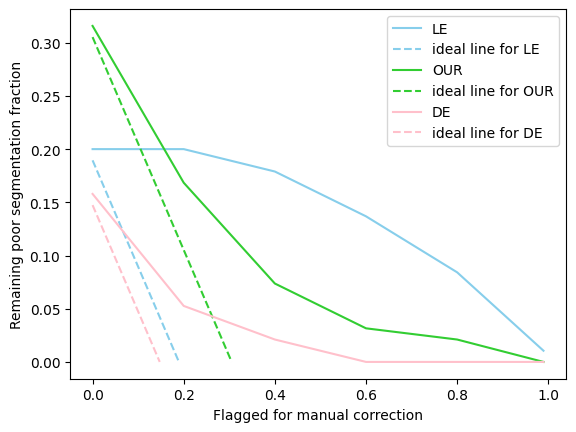

In [148]:
colors = ['skyblue', 'limegreen', 'pink']
structure = 'disc'
for i, data_pair in enumerate(models.items()):
    key, value = data_pair
    ideal_line_x = [i/n_samples for i in range(value[f'counts_{structure}'][2])]
    sns.lineplot(x=[i/n_samples for i in value[f'counts_{structure}'][1]], 
                 y=[i/n_samples for i in value[f'counts_{structure}'][0]], 
                 color=colors[i], label=key.upper())
    sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for {key.upper()}',
                linestyle='--', color=colors[i])

ideal_line_x = [i/n_samples for i in range(de_counts_disc[2])]
sns.lineplot(x=[i/n_samples for i in de_counts_disc[1]], 
                 y=[i/n_samples for i in de_counts_disc[0]], 
                 color=colors[-1], label='DE')
sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for DE',
                linestyle='--', color=colors[-1])


plt.xlabel('Flagged for manual correction')
plt.ylabel('Remaining poor segmentation fraction')

Text(0, 0.5, 'Remaining poor segmentation fraction')

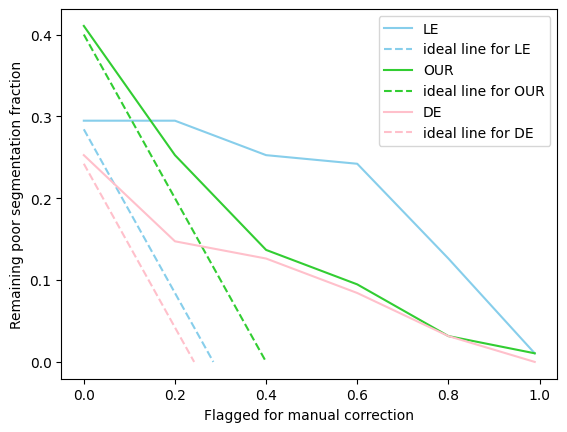

In [133]:
colors = ['skyblue', 'limegreen', 'pink']
structure = 'cup'
for i, data_pair in enumerate(models.items()):
    key, value = data_pair
    ideal_line_x = [i/n_samples for i in range(value[f'counts_{structure}'][2])]
    sns.lineplot(x=[i/n_samples for i in value[f'counts_{structure}'][1]], 
                 y=[i/n_samples for i in value[f'counts_{structure}'][0]], 
                 color=colors[i], label=key.upper())
    sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for {key.upper()}',
                linestyle='--', color=colors[i])

ideal_line_x = [i/n_samples for i in range(de_counts_cup[2])]
sns.lineplot(x=[i/n_samples for i in de_counts_cup[1]], 
                 y=[i/n_samples for i in de_counts_cup[0]], 
                 color=colors[-1], label='DE')
sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for DE',
                linestyle='--', color=colors[-1])

plt.xlabel('Flagged for manual correction')
plt.ylabel('Remaining poor segmentation fraction')

#### Hard sample detection

In [162]:
disc_threshold = 0.92
cup_threshold = 0.7

In [152]:
de_counts_disc[2]

2

Text(0, 0.5, 'Remaining poor segmentation fraction')

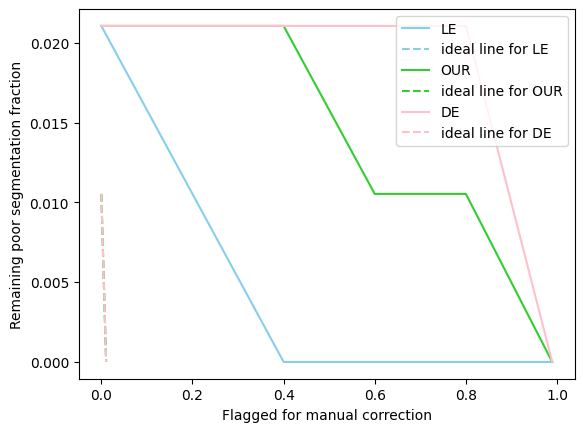

In [153]:
colors = ['skyblue', 'limegreen', 'pink']
structure = 'disc'
for i, data_pair in enumerate(models.items()):
    key, value = data_pair
    ideal_line_x = [i/n_samples for i in range(value[f'counts_{structure}'][2])]
    sns.lineplot(x=[i/n_samples for i in value[f'counts_{structure}'][1]], 
                 y=[i/n_samples for i in value[f'counts_{structure}'][0]], 
                 color=colors[i], label=key.upper())
    sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for {key.upper()}',
                linestyle='--', color=colors[i])

ideal_line_x = [i/n_samples for i in range(de_counts_disc[2])]
sns.lineplot(x=[i/n_samples for i in de_counts_disc[1]], 
                 y=[i/n_samples for i in de_counts_disc[0]], 
                 color=colors[-1], label='DE')
sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for DE',
                linestyle='--', color=colors[-1])


plt.xlabel('Flagged for manual correction')
plt.ylabel('Remaining poor segmentation fraction')

In [155]:
de_counts_cup[2]

21

Text(0, 0.5, 'Remaining poor segmentation fraction')

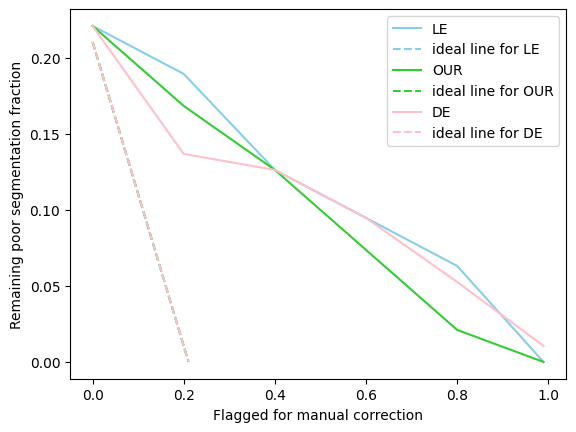

In [165]:
colors = ['skyblue', 'limegreen', 'pink']
structure = 'cup'
for i, data_pair in enumerate(models.items()):
    key, value = data_pair
    ideal_line_x = [i/n_samples for i in range(value[f'counts_{structure}'][2])]
    sns.lineplot(x=[i/n_samples for i in value[f'counts_{structure}'][1]], 
                 y=[i/n_samples for i in value[f'counts_{structure}'][0]], 
                 color=colors[i], label=key.upper())
    sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for {key.upper()}',
                linestyle='--', color=colors[i])

ideal_line_x = [i/n_samples for i in range(de_counts_cup[2])]
sns.lineplot(x=[i/n_samples for i in de_counts_cup[1]], 
                 y=[i/n_samples for i in de_counts_cup[0]], 
                 color=colors[-1], label='DE')
sns.lineplot(x=ideal_line_x, y=ideal_line_x[::-1], label=f'ideal line for DE',
                linestyle='--', color=colors[-1])

plt.xlabel('Flagged for manual correction')
plt.ylabel('Remaining poor segmentation fraction')

In [159]:
models['le']['counts_cup'], \
models['our']['counts_cup']

(([33, 27, 21, 13, 7, 0], [0, 19, 38, 57, 76, 94], 33),
 ([33, 27, 19, 12, 5, 0], [0, 19, 38, 57, 76, 94], 33))

#### compare with deep ensembles

In [41]:
checkpoints = [
    f'/home/kudaibergen/projects/grader_soup/outputs/RIGA_gt_annots_train_majority_vote_UnetDE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop{i}/checkpoints/best_loss.pt'
    for i in range(2, 8)
    ]

In [25]:
from models.unet import UNet

In [65]:
de_models = []
for chk in checkpoints:
    model = UNet()
    model.load_state_dict(torch.load(chk)['model'])
    model.eval()
    model.cuda()
    de_models.append(model)

In [88]:
val_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

outputs_model = []
for step, data in enumerate(val_loader):
    with torch.no_grad():
        imgs = data['image'].cuda()
        mask = data['mask']

        per_model_outputs = []
        for model in models:
            outputs = model({'image': imgs})
            outputs = torch.sigmoid(outputs['raw'])
            per_model_outputs.append(outputs)

        outputs_model.append(per_model_outputs)

In [74]:
def get_model_outputs_de(args, models, val_set):
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    outputs_model = []
    masks = []
    dice_vals_disc = []
    dice_vals_cup = []

    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
            gt_mask = mask_major_vote.cuda()

            per_model_outputs = []
            for model in models:
                outputs = model({'image': imgs})
                outputs = torch.sigmoid(outputs['raw'])
                per_model_outputs.append(outputs)
            
        preds = torch.stack(per_model_outputs, dim=0).sum(dim=0) / len(models)

        val_soft_dice_disc = get_soft_dice(
            outputs=preds[:, 0, :, :].cpu(),
            masks=gt_mask[:, 0, :, :].cpu()) * imgs.size(0)
        val_soft_dice_cup = get_soft_dice(
            outputs=preds[:, 1, :, :].cpu(), 
            masks=gt_mask[:, 1, :, :].cpu()) * imgs.size(0)

        outputs_model.append(per_model_outputs)
        dice_vals_disc.append(val_soft_dice_disc)
        dice_vals_cup.append(val_soft_dice_cup)
        masks.append(mask)
    return outputs_model, dice_vals_disc, dice_vals_cup, masks

In [75]:
model_outputs, dice_disc, dice_cup, masks = get_model_outputs_de(args, de_models, test_set)
de_outputs = (model_outputs, dice_disc, dice_cup, masks)

In [147]:
counts_poor_left_disc, counts_for_correction, count_poor_all_disc = get_img_counts(
    de_outputs[0], de_outputs[1], disc_threshold, disc_idx
)
de_counts_disc = (counts_poor_left_disc, counts_for_correction, count_poor_all_disc)

counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup = get_img_counts(
    de_outputs[0], de_outputs[2], cup_threshold, cup_idx
)
de_counts_cup = (counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup)

In [164]:
counts_poor_left_disc, counts_for_correction, count_poor_all_disc = get_img_counts(
    de_outputs[0], disc_dices, disc_threshold, disc_idx
)
de_counts_disc = (counts_poor_left_disc, counts_for_correction, count_poor_all_disc)

counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup = get_img_counts(
    de_outputs[0], cup_dices, cup_threshold, cup_idx
)
de_counts_cup = (counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup)

In [115]:
de_counts_cup

([57, 42, 36, 25, 12, 1], [0, 19, 38, 57, 76, 94], 57)

In [ ]:
for key, val in models.items():
    counts_poor_left_disc, counts_for_correction, count_poor_all_disc = get_img_counts(
        val['outputs'][0], disc_dices, disc_threshold, disc_idx
    )
    models[key]['counts_disc'] = (counts_poor_left_disc, counts_for_correction, count_poor_all_disc)

    counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup = get_img_counts(
        val['outputs'][0], cup_dices, cup_threshold, cup_idx
    )
    models[key]['counts_cup'] = (counts_poor_left_cup, counts_for_correction_cup, count_poor_all_cup)

In [72]:
val_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

outputs_model = []
masks = []
val_loss = 0.0
val_soft_dice_cup = 0.0
val_soft_dice_disc = 0.0

for step, data in enumerate(val_loader):
    with torch.no_grad():
        imgs = data['image'].cuda()
        mask = data['mask']

        mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
        gt_mask = mask_major_vote.cuda()

        per_model_outputs = []
        for model in de_models:
            outputs = model({'image': imgs})
            outputs = torch.sigmoid(outputs['raw'])
            per_model_outputs.append(outputs)

    preds = torch.stack(per_model_outputs, dim=0).sum(dim=0) / len(de_models)

    val_soft_dice_disc += get_soft_dice(
        outputs=preds[:, 0, :, :].cpu(),
        masks=gt_mask[:, 0, :, :].cpu()) * imgs.size(0)
    val_soft_dice_cup += get_soft_dice(
        outputs=preds[:, 1, :, :].cpu(), 
        masks=gt_mask[:, 1, :, :].cpu()) * imgs.size(0)
            
print(val_soft_dice_disc / test_set.__len__(), 
      val_soft_dice_cup / test_set.__len__())

0.9771740668698361 0.8746963965265374
